# Tutorial for GalaxyGenius

GalaxyGenius: A Mock Galaxy Image Generator for Various Telescopes from Hydrodynamical Simulations using [SKIRT](https://skirt.ugent.be/)

## Imports

In [1]:
import sys
sys.path.append('..')

from galaxyGenius.config import Configuration
from galaxyGenius.preprocess import PreProcess
from galaxyGenius.generation import DataGeneration
from galaxyGenius.postprocess import PostProcess

## Create configurations

In [2]:
from pathlib import Path
import os

config_files = Path('.').glob('config*.toml')
for file in config_files:
    os.remove(file)

In [3]:
# Initialize configuration
config = Configuration()
conf = config.get_config()

GALAXYGENIUS_DATA_DIR not set. Data directory falling to default path: ../Data
No conflicts in config. 👍


In [4]:
# add CSST and HSC surveys
config.add_survey('CSST,HSC')
conf = config.get_config()

CSST added.
HSC added.
No conflicts in config. 👍


In [5]:
# faceAndEdge will override other settings concerned with viewing angles
conf['faceAndEdge'] = True
conf = config.get_config()

No conflicts in config. 👍


In [6]:
# manually save config
config.save_config(conf)

In [7]:
# reload config
# Call this when config is further modified directly by file
conf = config.get_config()

No conflicts in config. 👍


## Data Preprocessing

Data preprocessing includes extracting particles and properties for stars, starforming regions, and dust particles and creation of .ski file for SKIRT execution.

In [8]:
# Initialize PreProcess
preprocess = PreProcess(conf)

In [9]:
# Get subhalos following conditions indicated in conf
subhalos = preprocess.get_subhalos()

6399 subhalos in snapshot 94 in stellar mass higher than 10^10.00 [M_sun]


`subhalos` includes subhalo numbers, subhalo IDs, and subhalo total star-forming rate.  
Additionally, the units are also shown.

In [10]:
subhalos

{'subhaloNum': 6399,
 'subhaloIDs': array([     0,      1,      2, ..., 644966, 646870, 649674]),
 'subhaloSFR': array([1.8883821 , 8.477463  , 0.87120724, ..., 0.02717319, 0.02758687,
        0.        ], dtype=float32),
 'units': ['1', '1', 'Msun/yr']}

In [11]:
# Initialize for subhalo with ID=253881
preprocess.subhalo(subhaloID=253881)

Stellar Mass of Subhalo 253881 is 10^11.63 [M_sun].


In [12]:
# Preparation of files for SKIRT to run
preprocess.prepare()

Retrieving Stellar and Gas particles.
Starforming regions:  276
Stars:  432621
Creating .ski file.
------Calculating face-on and edge viewing angles------
Face-on angle: (27.784266867331834, -138.8343342029161)
Edge-on angle: (70.8724920867215, 90.0)
------estimate memory usage------
numViews: 2
numSpatialPixels: 3013
numWavelengthPixels: 300
Estimated memory usage: 43.575 GB


## Ideal Data Cube Generation

Data generation includes SKIRT execution.

In [13]:
# initialize dataGeneration
dataGeneration = DataGeneration(conf)

In [14]:
# Run SKIRT
dataGeneration.runSKIRT()

Running SKIRT
20/01/2025 06:39:19.380   Welcome to SKIRT v9.0 (git 382ad4b built on 15/08/2024 at 01:46:45)
20/01/2025 06:39:19.380   Running on 2488h for xczhou
20/01/2025 06:39:19.380   Constructing a simulation from ski file 'skirt.ski'...
20/01/2025 06:39:19.421   Starting simulation skirt using 12 threads and a single process...
20/01/2025 06:39:19.421   Starting setup...
20/01/2025 06:39:19.421     Panchromatic wavelength regime
20/01/2025 06:39:19.421     With transfer medium
20/01/2025 06:39:19.421     Redshift: 0.06
20/01/2025 06:39:19.421     Luminosity distance: 277.531 Mpc
20/01/2025 06:39:19.421     Model and grid symmetry: 3D
20/01/2025 06:39:19.421     Photon life cycle: no explicit absorption; with forced scattering
20/01/2025 06:39:19.421   BruzualCharlotSEDFamily opened stored table /share/xczhou/SKIRT/resources/SKIRT9_Resources_Core/SED/BruzualCharlotSEDFamily_Chabrier_hr.stab
20/01/2025 06:39:19.421   ParticleSource reads smoothed source particles from text file /sh

## Mock Observation

Mock observation includes generating bandpass images for specific surveys.

In [15]:
# Initialize PostProcess
postprocess = PostProcess(subhaloID=253881, config=conf)

Run Postprocessing
Begin postprocessing for CSST


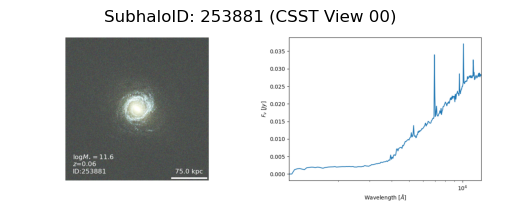

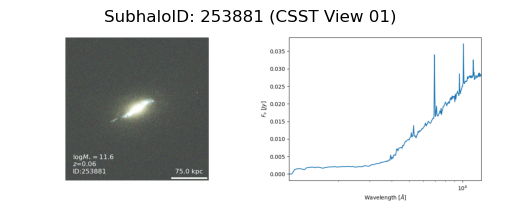

Finish postprocessing for CSST
Begin postprocessing for HSC


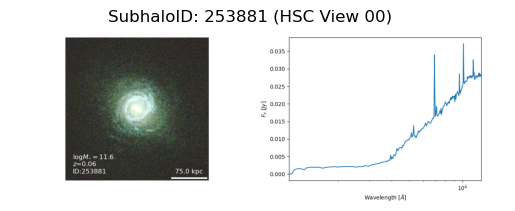

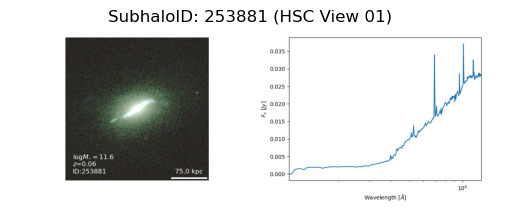

Finish postprocessing for HSC


In [16]:
# Run postprocessing
postprocess.runPostprocess(showImages=True)

## For multiple subhalos

Just simply initialize them by calling `prepare.subhalo(ID)` and call other methods as mentioned above.

In [17]:
for ID in [644966, 646870]:
    preprocess.subhalo(ID) # initialize for subhalo with ID
    preprocess.prepare()
    
    dataGeneration = DataGeneration(conf)
    dataGeneration.runSKIRT()
    
    postprocess = PostProcess(ID, conf)
    postprocess.runPostprocess()

## Outputs

`./dataCubes` are the dataCubes and SEDs of **SubhaloID** generated from SKIRT  
`./mock_CSST` are the bandpass images and SEDs of **SubhaloID** for CSST  
`./mock_HSC` are the bandpass images and SEDs of **SubhaloID** for HSC  

Folder trees:  
```bash
dataCubes/
└── Subhalo_(ID)/
    ├── dusts.txt # dust particles from gas particles
    ├── properties.json # properties of the subhalo and surveys
    ├── skirt_log.txt # log file of SKIRT
    ├── skirt_parameters.xml # SKIRT execution file 
    ├── skirt_view_(ViewID)_sed.dat # Generated SEDs
    ├── skirt_view_(ViewID)_total.fits # Generated dataCubes
    ├── starforming_regions.txt # starforming regions
    └── stars.txt # star particles
```

```bash
mock_(survey)/
└── Subhalo_(ID)/
    ├── galaxy_images.fits # bandpass images 
    ├── galaxy_SED_(ViewID).png # Plot of SEDs
    ├── galaxy_SEDs.fits # SEDs
    └── galaxy_view_(ViewID).png # Plot of bandpass images
```

## Bandpass images

Bandpass images are saved in pages of the fits file, and each page includes images in different views.

In [18]:
from astropy.io import fits

In [19]:
CSST_imgs = fits.open('mock_CSST/Subhalo_649674/galaxy_images.fits')

In [20]:
CSST_imgs[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  480                                                  
NAXIS2  =                  480                                                  
NAXIS3  =                    2                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
SNAPNUM =                   94 / Snapshot ID                                    
ID      =               649674 / Subhalo ID                                     
MASS    =   10.100269160520734 / Subhalo stellar mass, in log10 scale (Msun)    
SURVEY  = 'CSST    '           / Survey                                         
NFILTERS=                   

In [21]:
numfilters = CSST_imgs[1].header['nfilters']
for i in range(numfilters):
    i = i + 1
    header = CSST_imgs[i].header
    print(f'{header["survey"]}.{header["filter"]} Pixel Scale: {header["ps"]}')

CSST.NUV Pixel Scale: 0.074
CSST.u Pixel Scale: 0.074
CSST.g Pixel Scale: 0.074
CSST.r Pixel Scale: 0.074
CSST.i Pixel Scale: 0.074
CSST.z Pixel Scale: 0.074
CSST.y Pixel Scale: 0.074
